# Determinación variables en Matrícula
###     >> por Jordi Palau, Enrique Rodríguez, Raúl Zafra <<

Descripción proyecto

# Carga de librerías y de datos

Cargamos las librerías que utilizaremos en el desarrollo del proyecto:
* pandas
* numpy
* datetime
* dateutil
* pylab
* sklearn
* __future__ 

Parametrizamos la ubicación de los archivos para facilitar la carga de los datos

In [1]:
#cargamos las librerías
from __future__ import division
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
#from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import plotly.plotly as py
import plotly.graph_objs as go


#Definimos variables de entorno

base_dir = r'D:\JER_Capstone\Data'
#base_dir = r'/Data/'

#cargamos fichero
campanyes = pd.read_csv (os.path.join(base_dir,'dades-capstone-def3_2.csv'), parse_dates=True)


# Descriptivas de variables

Calculamos la edad para disponer de una variable adicional con la que construir el modelo: [ Edad en años = (hoy - fecha de nacimiento)/365,24 ]

Calculamos el número de intracciones por fecha y semestre para comparar la evolución de los intereses por día de campaña

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133240 entries, 0 to 133239
Data columns (total 27 columns):
identif_usuari                 130165 non-null object
producte_comprat_recode        133240 non-null object
punt_entrada_recode            133234 non-null object
area_prod_comprat_recode       133240 non-null object
subarea_prod_comprat_recode    132722 non-null object
tipus_producte_comprat         133240 non-null object
canal_recode                   133240 non-null object
idioma_recode                  55489 non-null object
prod_recode                    55489 non-null object
tipus_campanya_recode          55383 non-null object
data_ini_lead                  133240 non-null object
identif_lead                   133240 non-null object
semestre                       133240 non-null int64
acces                          66368 non-null object
data_acces                     73820 non-null object
data_ultima_conex              42939 non-null object
proposta                       7

C:\Users\erodriguezgar\Anaconda2\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\erodriguezgar\Anaconda2\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\erodriguezgar\Anaconda2\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

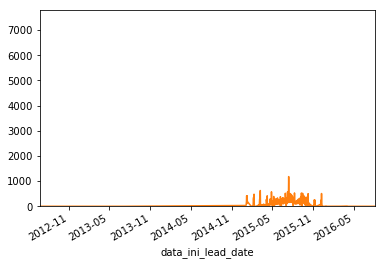

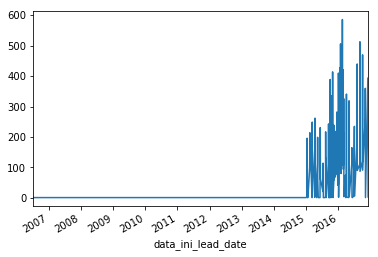

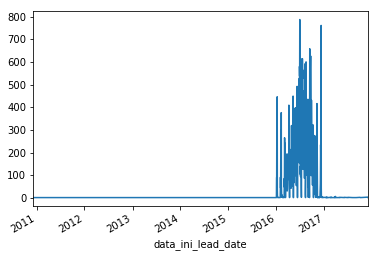

In [2]:
campanyes.info()

# cálculo de la edad en años
campanyes['data_naixement']=pd.to_datetime(campanyes['data_naixement'])
campanyes['edad_dias']=(pd.to_datetime(campanyes['data_ini_lead'])-pd.to_datetime(campanyes['data_naixement']))
campanyes['edad_anyos']=campanyes['edad_dias'].astype('timedelta64[D]')/365.24

edad_media_anyos=campanyes['edad_anyos'].mean()
edad_media_anyos

campanyes['edad_anyos'].hist(bins=90) 

edad_media_anyos

#validamos las columnas cargadas
campanyes.columns

# recuento de usuarios por semestre
campanyes.groupby(['semestre'])['identif_usuari'].count()

# recuento de usuarios por "estado de lead" vs "semestre"
campanyes.groupby(['semestre','estat_lead_recode'])['producte_comprat_recode'].count()

# recuento de usuarios por "matricula" vs "semestre"
campanyes.groupby(['semestre','matricula'])['producte_comprat_recode'].count()


# evolución campañas 20151, 20152 y 20161
campanya_20151 = campanyes[campanyes['semestre'] == 20151]
campanya_20152 = campanyes[campanyes['semestre'] == 20152]
campanya_20161 = campanyes[campanyes['semestre'] == 20161]
campanya_20151
campanya_20152
campanya_20161

campanya_20151['data_ini_lead_date']=pd.to_datetime(campanya_20151['data_ini_lead'])
campanya_20152['data_ini_lead_date']=pd.to_datetime(campanya_20152['data_ini_lead'])
campanya_20161['data_ini_lead_date']=pd.to_datetime(campanya_20161['data_ini_lead'])

#graficamos la evolución de leads campanya 20151, 20152 y 20161 por fecha
evol_campanya_20151=campanya_20151.groupby(['data_ini_lead_date'])['producte_comprat_recode'].count()
evol_campanya_20152=campanya_20152.groupby(['data_ini_lead_date'])['producte_comprat_recode'].count()
evol_campanya_20161=campanya_20161.groupby(['data_ini_lead_date'])['producte_comprat_recode'].count()

evol_campanya_20151

evol_campanya_20151.plot()
plt.show()
evol_campanya_20152.plot()
plt.show()
evol_campanya_20161.plot()
plt.show()

# Construcción fichero que agrega variables a nivel de código de persona

Construimos un fichero que agrega diversas métricas relacionadas con el perfil socio-demográfico de las personas interesada y las interacciones mantenidas con la organización:

__Perfil sociodemográfico__
* Sexo
* Edad

__Interacciones con la organización__
* Producto
* Punto de entrada
* Area de producto
* Subarea
* Tipo de producto
* Canal
* Idioma
* Semestre
* Región

__Matrícula__
* El usuario se ha "Matriculado" / "No se ha matriculado" 

In [4]:
# seleccionamos a los usuarios matriculados
campanya_matriculats = campanyes[campanyes['just_lead_recode'] == 'Matriculado']
campanya_matriculats = campanya_matriculats[['identif_usuari','just_lead_recode']] #seleccionamos la columna de matriculados
campanya_matriculats 


# agrupamos por identif_usuari y calculamos first, promedio, count_distinct para diferentes campos
Persones_Campanya_sexe = pd.DataFrame(campanyes.groupby(['identif_usuari'])['sexe'].first())  #sexo 
Persones_Campanya_edat = pd.DataFrame(campanyes.groupby(['identif_usuari'])['edad_anyos'].mean())  #edad
Persones_Campanya_prodcomp = pd.DataFrame(campanyes.groupby(['identif_usuari'])['producte_comprat_recode'].nunique())  #producto comprado
Persones_Campanya_puntentr = pd.DataFrame(campanyes.groupby(['identif_usuari'])['punt_entrada_recode'].nunique())  #punto entrada
Persones_Campanya_area = pd.DataFrame(campanyes.groupby(['identif_usuari'])['area_prod_comprat_recode'].nunique())  #área
Persones_Campanya_subarea = pd.DataFrame(campanyes.groupby(['identif_usuari'])['subarea_prod_comprat_recode'].nunique())  #subarea
Persones_Campanya_tipusprod = pd.DataFrame(campanyes.groupby(['identif_usuari'])['tipus_producte_comprat'].nunique())  #tipo de producto
Persones_Campanya_canal_recode = pd.DataFrame(campanyes.groupby(['identif_usuari'])['canal_recode'].nunique())  #canal
Persones_Campanya_idioma_recode = pd.DataFrame(campanyes.groupby(['identif_usuari'])['idioma_recode'].nunique())  #idioma
Persones_Campanya_semestre = pd.DataFrame(campanyes.groupby(['identif_usuari'])['semestre'].nunique())  #semestre
Persones_Campanya_regio = pd.DataFrame(campanyes.groupby(['identif_usuari'])['regio'].nunique())  #región

#añadimos índice para liberar el código de usuario que está siendo utilizado previamente como clave
Persones_Campanya_sexe = Persones_Campanya_sexe.reset_index(drop=False)
Persones_Campanya_edat = Persones_Campanya_edat.reset_index(drop=False)
Persones_Campanya_prodcomp = Persones_Campanya_prodcomp.reset_index(drop=False)
Persones_Campanya_puntentr = Persones_Campanya_puntentr.reset_index(drop=False)
Persones_Campanya_area = Persones_Campanya_area.reset_index(drop=False)
Persones_Campanya_subarea = Persones_Campanya_subarea.reset_index(drop=False)
Persones_Campanya_tipusprod = Persones_Campanya_tipusprod.reset_index(drop=False)
Persones_Campanya_canal_recode = Persones_Campanya_canal_recode.reset_index(drop=False)
Persones_Campanya_idioma_recode = Persones_Campanya_idioma_recode.reset_index(drop=False)
Persones_Campanya_semestre = Persones_Campanya_semestre.reset_index(drop=False)
Persones_Campanya_regio = Persones_Campanya_regio.reset_index(drop=False)

#unimos los dataframes con información por usuario a una tabla única
Persones_activitat = pd.merge(Persones_Campanya_sexe, Persones_Campanya_edat, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_prodcomp, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_puntentr, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_area, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_subarea, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_tipusprod, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_canal_recode, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_idioma_recode, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, Persones_Campanya_regio, on='identif_usuari')
Persones_activitat = pd.merge(Persones_activitat, campanya_matriculats,how='left', on='identif_usuari')
Persones_activitat['just_lead_recode'].fillna('No Matriculado', inplace=True)
Persones_activitat = Persones_activitat.rename(columns={'just_lead_recode':'estado_matricula'})
Persones_activitat.groupby('estado_matricula')['identif_usuari'].count()



Persones_activitat.describe() #descriptivas de los índices obtenidos

#Borramos las tablas intermedias
del Persones_Campanya_sexe
del Persones_Campanya_edat
del Persones_Campanya_prodcomp
del Persones_Campanya_puntentr
del Persones_Campanya_area
del Persones_Campanya_subarea
del Persones_Campanya_tipusprod
del Persones_Campanya_canal_recode
del Persones_Campanya_idioma_recode
del Persones_Campanya_semestre
del Persones_Campanya_regio
del campanya_matriculats



C:\Users\erodriguezgar\Anaconda2\lib\site-packages\pandas\core\groupby.py:3081: FutureWarning:

numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.



# Agrupación mediante K-Means

Uno de los objetivos de nuestra investigación es segmentar la base de datos en n grupos homogéneos (para n = 2,3,4, ...) de modo que los miembros de cada uno de ellos tengan características lo más parecidas posible entre ellos y sean lo más diferente posible respecto al resto de grupos.

Para segmentar la base de datos utilizaremos el método del K-means aplicado a las variables relacionadas con la personalidad de los estudiantes (pregunta 29 del cuestionario) como variable activa para, una vez obtenidos los segmentos, comparar los perfiles de los grupos obtenidos.

Una vez escogidas las variables, aplicamos los siguientes pasos para buscar la solución que nos permita obtener una mejor agrupación de los miembros del archivo:

* Obtener las soluciones de aplicar el método K-means por un número de agrupaciones comprendido entre 3 y 8 (es decir, 3, 4, 5 ... hasta 8 agrupaciones).
* Comparar el tamaño, el perfil y la estabilidad de las soluciones obtenidas; es decir, evaluar el tamaño, el perfil y el comportamiento de los grupos a medida que disgregan / agregamos los individuos en un número diferente de clústeres.
* Elegir la mejor solución: perfiles diferenciados y tamaños representativos. 

In [11]:

data_clustering = Persones_activitat.ix[:,3:11]
data_clustering

kmeans_n3 = KMeans(n_clusters=3)
kmeans_n3.fit(data_clustering)
kmeans_n3
centroid_n3 = kmeans_n3.cluster_centers_
cluster_n3 = kmeans_n3.labels_

kmeans_n4 = KMeans(n_clusters=4)
kmeans_n4.fit(data_clustering)
kmeans_n4
centroid_n4 = kmeans_n4.cluster_centers_
cluster_n4 = kmeans_n4.labels_

kmeans_n5 = KMeans(n_clusters=5)
kmeans_n5.fit(data_clustering)
kmeans_n5
centroid_n5 = kmeans_n5.cluster_centers_
cluster_n5 = kmeans_n5.labels_

kmeans_n6 = KMeans(n_clusters=6)
kmeans_n6.fit(data_clustering)
kmeans_n6
centroid_n6 = kmeans_n6.cluster_centers_
cluster_n6 = kmeans_n6.labels_

kmeans_n7 = KMeans(n_clusters=7)
kmeans_n7.fit(data_clustering)
kmeans_n7
centroid_n7 = kmeans_n7.cluster_centers_
cluster_n7 = kmeans_n7.labels_

kmeans_n8 = KMeans(n_clusters=8)
kmeans_n8.fit(data_clustering)
kmeans_n8
centroid_n8 = kmeans_n8.cluster_centers_
cluster_n8 = kmeans_n8.labels_


print (centroid_n3)
print (centroid_n4)
print (centroid_n5)
print (centroid_n6)
print (centroid_n7)
print (centroid_n8)

cluster_n3=pd.DataFrame(cluster_n3)
cluster_n4=pd.DataFrame(cluster_n4)
cluster_n5=pd.DataFrame(cluster_n5)
cluster_n6=pd.DataFrame(cluster_n6)
cluster_n7=pd.DataFrame(cluster_n7)
cluster_n8=pd.DataFrame(cluster_n8)

cluster_n3 = cluster_n3.rename(columns={0:'cluster_n3'})
cluster_n4 = cluster_n4.rename(columns={0:'cluster_n4'})
cluster_n5 = cluster_n5.rename(columns={0:'cluster_n5'})
cluster_n6 = cluster_n6.rename(columns={0:'cluster_n6'})
cluster_n7 = cluster_n7.rename(columns={0:'cluster_n7'})
cluster_n8 = cluster_n8.rename(columns={0:'cluster_n8'})

frame=[Persones_activitat,cluster_n3,cluster_n4,cluster_n5,cluster_n6,cluster_n7,cluster_n8]
Persones_activitat_cluster=pd.concat(frame,axis=1)



C:\Users\erodriguezgar\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



[[  1.06540001e+00   1.05951579e+00   1.00035662e+00   9.94214843e-01
    1.00265483e+00   1.00003962e+00  -4.55246951e-13   8.38570353e-01]
 [  2.32643247e+00   1.60118999e+00   1.68913522e+00   2.03765588e+00
    1.19325128e+00   1.46051023e+00   6.35178091e-01   9.40337436e-01]
 [  1.04278798e+00   1.04635159e+00   1.00012288e+00   9.97861830e-01
    1.00172037e+00   1.05451105e+00   1.00351446e+00   7.40986507e-01]]
[[  1.03014016e+00   1.02476552e+00   1.00005269e+00   1.00774581e+00
    1.00274001e+00   1.01359469e+00   5.62598799e-01  -3.82360810e-13]
 [  1.08531811e+00   1.06501981e+00   1.00041948e+00   1.00766721e+00
    1.00261011e+00   1.00000000e+00  -2.34756659e-13   1.00074575e+00]
 [  1.09689086e+00   1.09936548e+00   1.00022208e+00   9.97366751e-01
    1.00368020e+00   1.10748731e+00   1.00494924e+00   1.00076142e+00]
 [  2.39954110e+00   1.58599362e+00   1.84317638e+00   2.19303671e+00
    1.22895052e+00   1.42138867e+00   6.25698324e-01   9.50418994e-01]]
[[  3.62726

# Clasificación mediante KNN

Este es un método de clasificación no paramétrico, que estima el valor de la probabilidad a posteriori de que un elemento x pertenezca a una clase en particular a partir de la información proporcionada por el conjunto de prototipos. La regresión KNN se calcula simplemente tomando el promedio del punto k más cercano al punto que se está probando.

Feature space holds 103432 observations and 8 features
Unique target labels: [0 1]


C:\Users\erodriguezgar\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Loading ok.
Mean accuracy: 0.589808301511


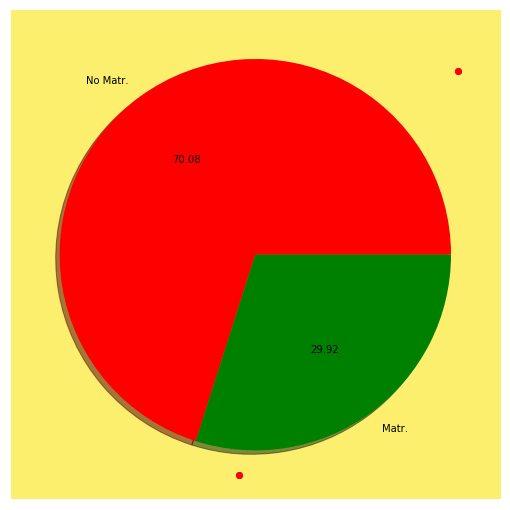

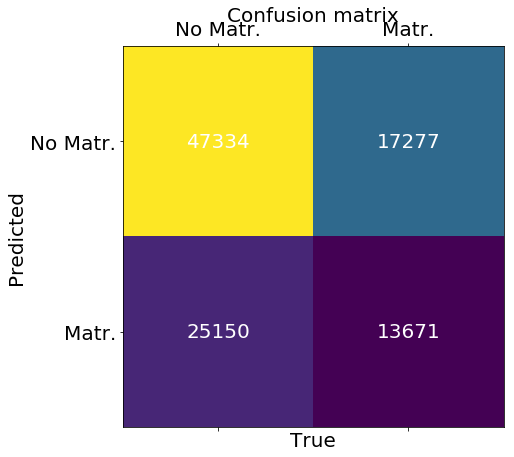

             precision    recall  f1-score   support

          0       0.73      0.65      0.69     72484
          1       0.35      0.44      0.39     30948

avg / total       0.62      0.59      0.60    103432

Mean accuracy: 0.567571838789


KeyboardInterrupt: 

In [5]:

# Isolate target data
churn_result = Persones_activitat['estado_matricula']
y = np.where(churn_result == 'Matriculado',1,0)

# We don't need these columns
to_drop = ['identif_usuari','sexe','edad_anyos','estado_matricula']
churn_feat_space = Persones_activitat.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
#yes_no_cols = ["Int'l Plan","VMail Plan"]
#churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)


%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(np.c_[len(y)-np.sum(y),np.sum(y)][0],labels=['No Matr.','Matr.'],colors=['r','g'],shadow=True,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)

import pickle
ofname = open('churn_data.pkl', 'wb')
s = pickle.dump([X,y,features],ofname)
ofname.close()



#Let's see what the boundary looks like in a toy problem.

MAXN=10
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics

delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];


#Evaluate the model for a given weight
clf = neighbors.KNeighborsClassifier(1)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)


#Let's see what the boundary looks like in a toy problem.

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

clf = neighbors.KNeighborsClassifier(3)
clf.fit(X,y.ravel())
Z2=clf.predict(data)
Z2.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.4, vmin=-1, vmax=1)
plt.imshow(Z2, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.2, vmin=-1, vmax=1)

plt.contour(XX,YY,Z2,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)


#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = data[1]
print 'Loading ok.'



from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics
acc = np.zeros((5,))
i=0
kf=cross_validation.KFold(n=y.shape[0], n_folds=5, shuffle=False, random_state=0)
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dt = neighbors.KNeighborsClassifier(n_neighbors=1)
    dt.fit(X_train,y_train)
    yhat[test_index] = dt.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print 'Mean accuracy: '+ str(np.mean(acc))



def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(2):
        for j in xrange(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['No Matr.', 'Matr.'])
print metrics.classification_report(y,yhat)



# Standarize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


from sklearn import metrics
acc_snooping = np.zeros((5,))
i=0
kf=cross_validation.KFold(n=y.shape[0], n_folds=5, shuffle=False, random_state=0)
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dt = neighbors.KNeighborsClassifier(3)
    dt.fit(X_train,y_train)
    yhat[test_index] = dt.predict(X_test)
    acc_snooping[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print 'Mean accuracy: '+ str(np.mean(acc_snooping))



#NO SNOOPING
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    dt = neighbors.KNeighborsClassifier(3)
    dt.fit(X_train,y_train)
    X_test = scaler.transform(X_test)
    yhat[test_index] = dt.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print 'Mean accuracy: '+ str(np.mean(acc))


acct=np.c_[acc_snooping,acc]
plt.boxplot(acct);
for i in xrange(2):
    xderiv = (i+1)*np.ones(acct[:,i].shape)+(np.random.rand(5,)-0.5)*0.1
    plt.plot(xderiv,acct[:,i],'ro',alpha=0.3)
ax = plt.gca()
ax.set_xticklabels(['snooping', 'no snooping'])



def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(2):
        for j in xrange(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['No Matr.', 'Matr.'])
print metrics.classification_report(y,yhat)



def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    ax.text(0, 0, 'TP', va='center', ha='center',color='white',size=20)
    ax.text(0, 1, 'FN', va='center', ha='center',color='white',size=20)
    ax.text(1, 0, 'FP', va='center', ha='center',color='white',size=20)
    ax.text(1, 1, 'TN', va='center', ha='center',color='white',size=20)            
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['positive', 'negative'])



# Let us check the concepts with churn as the positive class
TP = np.sum(np.logical_and(yhat==1,y==1))
TN = np.sum(np.logical_and(yhat==0,y==0))
FP = np.sum(np.logical_and(yhat==1,y==0))
FN = np.sum(np.logical_and(yhat==0,y==1))

print 'TP: ' + str(TP)
print 'TN: ' + str(TN)
print 'FP: ' + str(FP)
print 'FN: ' + str(FN)
print 'sensitivity/recall: '+ str(TP/(TP+FN))
print 'precision: '+ str(TP/(TP+FP))

# Clasificación mediante Árboles de decisión sencillos

Los Arboles de Decision son diagramas con construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema. Los Arboles de Decision están compuestos por nodos interiores, nodos terminales y ramas que emanan de los nodos interiores. Cada nodo interior en el árbol contiene una prueba de un atributo, y cada rama representa un valor distinto del atributo. Siguiendo las ramas desde el nodo raíz hacia abajo, cada ruta finalmente termina en un nodo terminal creando una segmentación de los datos. 

Loading ok.
Mean accuracy: 0.70723060718


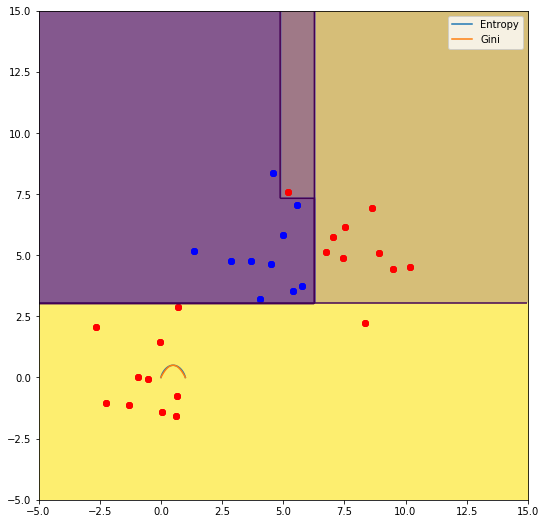

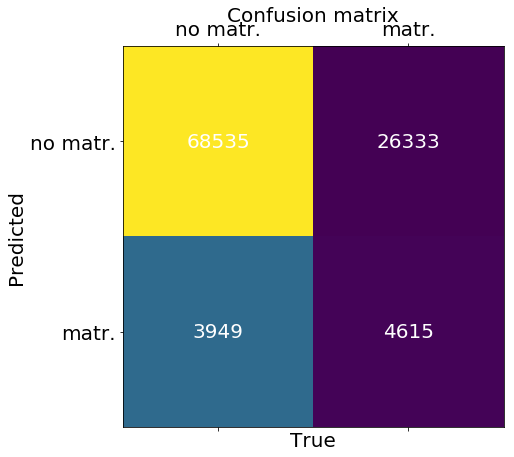

             precision    recall  f1-score   support

          0       0.72      0.95      0.82     72484
          1       0.54      0.15      0.23     30948

avg / total       0.67      0.71      0.64    103432

TP: 4615
TN: 68535
FP: 3949
FN: 26333
sensitivity/recall: 0.149121106372
precision: 0.538883699206


In [14]:

%matplotlib inline
#Let's see what the boundary looks like in a toy problem.
%reset -f

import numpy as np
import matplotlib.pyplot as plt
MAXN=10
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

from sklearn import tree
from sklearn import metrics

delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

#Export Tree
import os
dotfile = tree.export_graphviz(clf, out_file = "toy_tree.dot")

os.system("dot -Tpng toy_tree.dot -o toy_tree.png")

from IPython.core.display import Image
Image("toy_tree.png")

clf = tree.DecisionTreeClassifier(random_state=0,max_depth=1)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

clf = tree.DecisionTreeClassifier(random_state=0, max_depth=2)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)



entropy = lambda p: -np.sum(p * np.log2(p)) if not 0 in p else 0
gini = lambda p: 1. - (np.array(p)**2).sum()
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p])/2. for p in pvals], label='Entropy')
plt.plot(pvals, [gini([p,1-p]) for p in pvals], label='Gini')
plt.legend()

%reset -f
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = data[1]
features = data[2]
print 'Loading ok.'

#NO SNOOPING
import numpy as np
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import metrics


kf=cross_validation.KFold(n=y.shape[0], n_folds=5, shuffle=False, random_state=0)

acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train,y_train)
    X_test = scaler.transform(X_test)
    yhat[test_index] = dt.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print 'Mean accuracy: '+ str(np.mean(acc))

import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(2):
        for j in xrange(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['No Matr.', 'Matr.'])
print metrics.classification_report(y,yhat)

# Let us check the concepts with churn as the positive class
TP = np.sum(np.logical_and(yhat==1,y==1))
TN = np.sum(np.logical_and(yhat==0,y==0))
FP = np.sum(np.logical_and(yhat==1,y==0))
FN = np.sum(np.logical_and(yhat==0,y==1))

print 'TP: ' + str(TP)
print 'TN: ' + str(TN)
print 'FP: ' + str(FP)
print 'FN: ' + str(FN)
print 'sensitivity/recall: '+ str(TP/(TP+FN))
print 'precision: '+ str(TP/(TP+FP))

import os
#Let us check the the first three levels of the tree. GraphViz and PyDot are needed.
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
dt.fit(Xs,y)

#Export Tree

dotfile = tree.export_graphviz(dt, out_file = "churn.dot", feature_names = features)

os.system("dot -Tpng churn.dot -o churn.png")

from IPython.core.display import Image
Image("churn.png")





# Clasificación mediante Random Forest

Feature space holds 103432 observations and 9 features
Unique target labels: [0 1]
score all train:  0.721130791244
accuracy RF for crossvalidation 0is:0.628866976025
accuracy RF for crossvalidation 1is:0.605568445476
accuracy RF for crossvalidation 2is:0.548680266847
accuracy RF for crossvalidation 3is:0.535724644687
accuracy RF for crossvalidation 4is:0.593831576912
accuracy RF for crossvalidation 5is:0.552064198008
accuracy RF for crossvalidation 6is:0.722227593542
accuracy RF for crossvalidation 7is:0.975539011892
accuracy RF for crossvalidation 8is:0.985110702891
accuracy RF for crossvalidation 9is:0.989461471527
Mean accuracy RF with 10 estimators: 0.713707488781


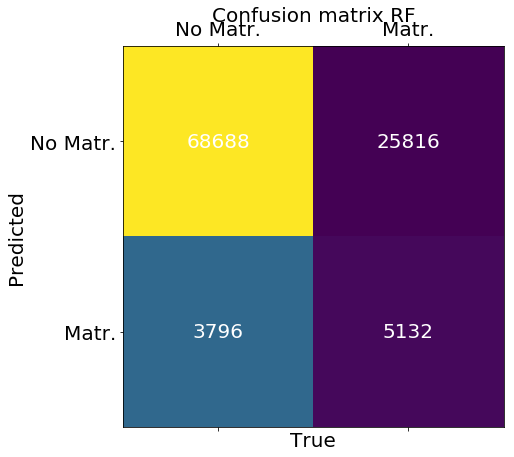

             precision    recall  f1-score   support

          0       0.73      0.95      0.82     72484
          1       0.57      0.17      0.26     30948

avg / total       0.68      0.71      0.65    103432

[ 0.16697319  0.06624598  0.02923058  0.04589255  0.01867424  0.07928812
  0.19105901  0.342388    0.06024832]
Index([u'producte_comprat_recode', u'punt_entrada_recode',
       u'area_prod_comprat_recode', u'subarea_prod_comprat_recode',
       u'tipus_producte_comprat', u'canal_recode', u'idioma_recode', u'regio',
       u'sexe_factor'],
      dtype='object')


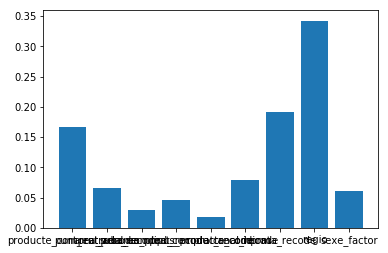

In [7]:
# factoritzar variables
pd.factorize(Persones_activitat['sexe'])
Persones_activitat['sexe_factor'] = pd.factorize(Persones_activitat['sexe'])[0]
Persones_activitat['estado_matricula_factor'] = pd.factorize(Persones_activitat['estado_matricula'])[0]

# Isolate target data
churn_result = Persones_activitat['estado_matricula']
y = np.where(churn_result == 'Matriculado',1,0)

# We don't need these columns
#to_drop = ['identif_usuari','sexe','edad_anyos','estado_matricula']
to_drop = ['identif_usuari','sexe','edad_anyos','estado_matricula', 'estado_matricula_factor']
churn_feat_space = Persones_activitat.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
#yes_no_cols = ["Int'l Plan","VMail Plan"]
#churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

### Random Forest
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=1)
clf.fit(X, y)
clf_probs = clf.predict_proba(X)
clf.score(X, y)
print "score all train: ", clf.score(X,y)

df_clf_probs = pd.DataFrame(clf_probs)
df_clf_probs.describe()

from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics

folds = 10
kf=cross_validation.KFold(n=y.shape[0], n_folds=folds, shuffle=False, random_state=0)
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
acc = np.zeros((folds,))
i=0
N = 10
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=N)
    clf.fit(X_train,y_train)
    yhat[test_index] = clf.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    print "accuracy RF for crossvalidation " + str(i) + "is:" + str(acc[i])
    i=i+1
print 'Mean accuracy RF with '+ str(N) + " estimators: "+ str(np.mean(acc))

def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix RF',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(2):
        for j in xrange(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['No Matr.', 'Matr.'])
print metrics.classification_report(y,yhat)
print clf.feature_importances_
feature_importances = clf.feature_importances_
prova = pd.DataFrame(np.transpose(feature_importances))
print churn_feat_space.columns 
feature_weight = pd.DataFrame(columns=churn_feat_space.columns)
feature_weight.loc[0] = [feature_importances[i] for i in range(feature_importances.shape[0])]

labels = churn_feat_space.columns
plt.bar(range(feature_importances.shape[0]), feature_importances,  align='center')

plt.xticks(range(feature_importances.shape[0]), labels)
plt.show()